In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/7981.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/6234.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/1269.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/3863.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/6241.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/10304.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/623.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/2193.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/11925.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/3750.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/11378.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/2008.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/10730.jpg
/kaggle/input/dog-and-cat-classification-dataset/PetImages/Do

In [16]:
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, random_split, Subset
import torch

data_dir = "/kaggle/input/dog-and-cat-classification-dataset/PetImages"

def add_gaussian_noise(tensor, mean=0.0, std=0.05):
    return tensor + torch.randn_like(tensor) * std

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.03),

    transforms.RandomApply([
        transforms.RandomRotation(10),
    ], p=0.3),

    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=5, sigma=(0.01, 1.0))
    ], p=0.45),
    
    transforms.ToTensor(),
    
    transforms.RandomApply([
        transforms.Lambda(lambda x: add_gaussian_noise(x, std=0.03))
    ], p=0.3),
    
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

raw_dataset = datasets.ImageFolder(data_dir)

total = len(raw_dataset)
train_len = int(0.8 * total)
val_len = int(0.1 * total)
test_len = total - train_len - val_len

g = torch.Generator().manual_seed(42)

train_idx, val_idx, test_idx = random_split(
    raw_dataset, 
    [train_len, val_len, test_len],
    generator=g
)

train_ds = Subset(
    datasets.ImageFolder(data_dir, transform=train_transform),
    train_idx.indices
)

val_ds = Subset(
    datasets.ImageFolder(data_dir, transform=test_transform),
    val_idx.indices
)

test_ds = Subset(
    datasets.ImageFolder(data_dir, transform=test_transform),
    test_idx.indices
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
    
        self.features = nn.Sequential(
            block(3, 32),
            block(32, 64),
            block(64, 128),
            block(128, 256),
            block(256, 512),
        )
    
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [36]:
import torchvision.models as models
import torch.nn as nn

def build_resnet18(num_classes=1):
    model = models.resnet18(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(512, num_classes)
    return model

# Results

In [18]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import time
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import pandas as pd

# Set style for beautiful plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

def evaluate_model_detailed(model, test_loader, device="cpu"):
    """
    Comprehensive evaluation returning multiple metrics.
    """
    model = model.to(device)
    model.eval()
    
    y_true = []
    y_pred = []
    y_proba = []
    batch_times = []
    
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Measure inference time per batch
            start_time = time.time()
            outputs = model(imgs)
            batch_time = (time.time() - start_time) * 1000  # ms
            batch_times.append(batch_time)
            
            # Get predictions
            if outputs.dim() == 1:
                outputs = outputs.unsqueeze(1)
            
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
            if probs.ndim == 0:
                probs = np.array([probs])
            
            preds = (probs > 0.5).astype(int)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)
            y_proba.extend(probs)
    
    # Convert to arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    
    # Calculate metrics
    accuracy = (y_true == y_pred).mean()
    auc = roc_auc_score(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Timing statistics
    avg_batch_time = np.mean(batch_times)
    std_batch_time = np.std(batch_times)
    total_time = sum(batch_times)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'ap': ap,
        'confusion_matrix': cm,
        'avg_batch_time_ms': avg_batch_time,
        'std_batch_time_ms': std_batch_time,
        'total_time_ms': total_time,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_proba': y_proba
    }


def get_model_info(model, model_path=None):
    """
    Extract detailed model information.
    """
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Count zero parameters (sparsity)
    zero_params = sum((p == 0).sum().item() for p in model.parameters())
    sparsity = 100.0 * zero_params / total_params
    
    # Model size on disk
    if model_path and os.path.exists(model_path):
        size_mb = os.path.getsize(model_path) / (1024 * 1024)
    else:
        # Estimate from state dict
        import io
        buffer = io.BytesIO()
        torch.save(model.state_dict(), buffer)
        size_mb = buffer.tell() / (1024 * 1024)
    
    # Memory footprint (approximate)
    memory_mb = total_params * 4 / (1024 * 1024)  # 4 bytes per float32
    
    # Layer counts
    num_conv = sum(1 for m in model.modules() if isinstance(m, nn.Conv2d))
    num_linear = sum(1 for m in model.modules() if isinstance(m, nn.Linear))
    num_bn = sum(1 for m in model.modules() if isinstance(m, nn.BatchNorm2d))
    
    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'zero_params': zero_params,
        'sparsity': sparsity,
        'size_mb': size_mb,
        'memory_mb': memory_mb,
        'num_conv': num_conv,
        'num_linear': num_linear,
        'num_bn': num_bn
    }


def compare_models(original_model, pruned_model, quantized_model, 
                  pruned_quantized_model=None,
                  test_loader=None, save_dir="model_comparison",
                  original_path=None, pruned_path=None, quantized_path=None,
                  pruned_quantized_path=None):
    """
    Comprehensive comparison of 3 or 4 models with visualizations.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    print("="*80)
    print("COMPREHENSIVE MODEL COMPARISON")
    print("="*80)
    
    # ========================================================================
    # Collect all metrics
    # ========================================================================
    
    models = {
        'Original': (original_model, original_path),
        'Pruned': (pruned_model, pruned_path),
        'Quantized': (quantized_model, quantized_path)
    }
    
    # Add pruned+quantized if provided
    if pruned_quantized_model is not None:
        models['Pruned+Quantized'] = (pruned_quantized_model, pruned_quantized_path)
    
    results = {}
    
    for name, (model, path) in models.items():
        print(f"\n📊 Evaluating {name} model...")
        
        # Ensure model is on CPU
        model = model.to("cpu")
        model.eval()
        
        # Get model info
        info = get_model_info(model, path)
        
        # Evaluate performance
        metrics = evaluate_model_detailed(model, test_loader, "cpu")
        
        # Combine results
        results[name] = {**info, **metrics}
        
        print(f"  ✓ Size: {info['size_mb']:.2f} MB")
        print(f"  ✓ Accuracy: {metrics['accuracy']*100:.2f}%")
        print(f"  ✓ Inference: {metrics['avg_batch_time_ms']:.2f} ms/batch")
    
    # ========================================================================
    # Create comparison DataFrame
    # ========================================================================
    
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Size (MB)': [results[k]['size_mb'] for k in results.keys()],
        'Parameters': [results[k]['total_params'] for k in results.keys()],
        'Sparsity (%)': [results[k]['sparsity'] for k in results.keys()],
        'Accuracy (%)': [results[k]['accuracy']*100 for k in results.keys()],
        'Precision (%)': [results[k]['precision']*100 for k in results.keys()],
        'Recall (%)': [results[k]['recall']*100 for k in results.keys()],
        'F1-Score (%)': [results[k]['f1']*100 for k in results.keys()],
        'AUC': [results[k]['auc'] for k in results.keys()],
        'Avg Time (ms)': [results[k]['avg_batch_time_ms'] for k in results.keys()],
    })
    
    # Save CSV
    csv_path = os.path.join(save_dir, "comparison_table.csv")
    comparison_df.to_csv(csv_path, index=False)
    print(f"\n✓ Comparison table saved to: {csv_path}")
    
    # ========================================================================
    # VISUALIZATION 1: Model Size Comparison
    # ========================================================================
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Size comparison
    ax = axes[0, 0]
    models_list = list(results.keys())
    sizes = [results[k]['size_mb'] for k in models_list]
    
    # Color palette for 4 models
    if len(models_list) == 4:
        colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    else:
        colors = ['#3498db', '#e74c3c', '#2ecc71']
    
    bars = ax.bar(models_list, sizes, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Size (MB)', fontsize=12, fontweight='bold')
    ax.set_title('Model Size Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, size in zip(bars, sizes):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{size:.2f} MB',
                ha='center', va='bottom', fontweight='bold')
    
    # Calculate and show reduction
    original_size = sizes[0]
    for i, (model_name, size) in enumerate(zip(models_list[1:], sizes[1:]), 1):
        reduction = (1 - size/original_size) * 100
        ax.text(i, size/2, f'{reduction:.1f}%\nreduction', 
                ha='center', va='center', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 2: Accuracy comparison
    ax = axes[0, 1]
    accuracies = [results[k]['accuracy']*100 for k in models_list]
    bars = ax.bar(models_list, accuracies, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    ax.set_ylim([min(accuracies) - 2, 100])
    ax.grid(axis='y', alpha=0.3)
    
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%',
                ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Inference speed comparison
    ax = axes[1, 0]
    times = [results[k]['avg_batch_time_ms'] for k in models_list]
    bars = ax.bar(models_list, times, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Avg Inference Time (ms/batch)', fontsize=12, fontweight='bold')
    ax.set_title('Inference Speed Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    for bar, t in zip(bars, times):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{t:.2f} ms',
                ha='center', va='bottom', fontweight='bold')
    
    # Calculate speedup
    original_time = times[0]
    for i, (model_name, t) in enumerate(zip(models_list[1:], times[1:]), 1):
        if t < original_time:
            speedup = original_time / t
            ax.text(i, t/2, f'{speedup:.2f}x\nfaster', 
                    ha='center', va='center', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 4: Multi-metric comparison
    ax = axes[1, 1]
    metrics_to_plot = ['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1-Score (%)']
    x = np.arange(len(metrics_to_plot))
    
    # Adjust width based on number of models
    width = 0.8 / len(models_list)
    
    for i, (model_name, color) in enumerate(zip(models_list, colors)):
        values = [
            results[model_name]['accuracy']*100,
            results[model_name]['precision']*100,
            results[model_name]['recall']*100,
            results[model_name]['f1']*100
        ]
        offset = (i - len(models_list)/2 + 0.5) * width
        ax.bar(x + offset, values, width, label=model_name, 
               color=color, alpha=0.7, edgecolor='black')
    
    ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 105])
    
    plt.tight_layout()
    plot1_path = os.path.join(save_dir, "comparison_metrics.png")
    plt.savefig(plot1_path, dpi=300, bbox_inches='tight')
    print(f"✓ Metrics plot saved to: {plot1_path}")
    plt.show()
    
    # ========================================================================
    # VISUALIZATION 2: Detailed Performance Dashboard
    # ========================================================================
    
    # Adjust grid based on number of models
    if len(models_list) == 4:
        fig = plt.figure(figsize=(18, 12))
        gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    else:
        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: Parameter count
    ax1 = fig.add_subplot(gs[0, 0])
    params = [results[k]['total_params']/1e6 for k in models_list]
    ax1.bar(models_list, params, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Parameters (Millions)', fontsize=11, fontweight='bold')
    ax1.set_title('Parameter Count', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    for i, (name, p) in enumerate(zip(models_list, params)):
        ax1.text(i, p, f'{p:.2f}M', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Sparsity
    ax2 = fig.add_subplot(gs[0, 1])
    sparsities = [results[k]['sparsity'] for k in models_list]
    ax2.bar(models_list, sparsities, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Sparsity (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Model Sparsity (% Zero Weights)', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    for i, (name, s) in enumerate(zip(models_list, sparsities)):
        ax2.text(i, s, f'{s:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: AUC Scores
    ax3 = fig.add_subplot(gs[0, 2])
    aucs = [results[k]['auc'] for k in models_list]
    ax3.bar(models_list, aucs, color=colors, alpha=0.7, edgecolor='black')
    ax3.set_ylabel('AUC Score', fontsize=11, fontweight='bold')
    ax3.set_title('ROC AUC Score', fontsize=12, fontweight='bold')
    ax3.set_ylim([0.5, 1.0])
    ax3.grid(axis='y', alpha=0.3)
    for i, (name, auc) in enumerate(zip(models_list, aucs)):
        ax3.text(i, auc, f'{auc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Plots: Confusion Matrices (one row per model)
    if len(models_list) == 4:
        # 4 models: use first row for confusion matrices
        for idx, (model_name, color) in enumerate(zip(models_list, colors)):
            ax = fig.add_subplot(gs[1, idx])
            cm = results[model_name]['confusion_matrix']
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       cbar=False, ax=ax, square=True,
                       xticklabels=['Neg', 'Pos'],
                       yticklabels=['Neg', 'Pos'])
            ax.set_title(f'{model_name}', fontsize=11, fontweight='bold')
            ax.set_ylabel('True', fontsize=9)
            ax.set_xlabel('Predicted', fontsize=9)
        
        # Adjust other plot positions for 4 models
        pos_size_acc = gs[2, 0]
        pos_speed_acc = gs[2, 1]
        pos_summary = gs[2, 2]
        pos_compression = gs[2, 3]
        pos_radar = gs[3, :2]
        pos_efficiency = gs[3, 2:]
        
    else:
        # 3 models: use second row for confusion matrices
        for idx, (model_name, color) in enumerate(zip(models_list, colors)):
            ax = fig.add_subplot(gs[1, idx])
            cm = results[model_name]['confusion_matrix']
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       cbar=False, ax=ax, square=True,
                       xticklabels=['Negative', 'Positive'],
                       yticklabels=['Negative', 'Positive'])
            ax.set_title(f'{model_name} Model', fontsize=12, fontweight='bold')
            ax.set_ylabel('True Label', fontsize=10)
            ax.set_xlabel('Predicted Label', fontsize=10)
        
        pos_size_acc = gs[2, 0]
        pos_speed_acc = gs[2, 1]
        pos_summary = gs[2, 2]
    
    # Plot: Size vs Accuracy Trade-off
    ax7 = fig.add_subplot(pos_size_acc)
    sizes = [results[k]['size_mb'] for k in models_list]
    accs = [results[k]['accuracy']*100 for k in models_list]
    
    for i, (name, color) in enumerate(zip(models_list, colors)):
        ax7.scatter(sizes[i], accs[i], s=300, c=color, alpha=0.6, 
                   edgecolors='black', linewidth=2, label=name)
        ax7.annotate(name, (sizes[i], accs[i]), 
                    textcoords="offset points", xytext=(0,10),
                    ha='center', fontweight='bold', fontsize=9)
    
    ax7.set_xlabel('Model Size (MB)', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax7.set_title('Size vs Accuracy Trade-off', fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3)
    ax7.legend(fontsize=8)
    
    # Plot: Speed vs Accuracy Trade-off
    ax8 = fig.add_subplot(pos_speed_acc)
    times = [results[k]['avg_batch_time_ms'] for k in models_list]
    
    for i, (name, color) in enumerate(zip(models_list, colors)):
        ax8.scatter(times[i], accs[i], s=300, c=color, alpha=0.6,
                   edgecolors='black', linewidth=2, label=name)
        ax8.annotate(name, (times[i], accs[i]),
                    textcoords="offset points", xytext=(0,10),
                    ha='center', fontweight='bold', fontsize=9)
    
    ax8.set_xlabel('Inference Time (ms/batch)', fontsize=11, fontweight='bold')
    ax8.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax8.set_title('Speed vs Accuracy Trade-off', fontsize=12, fontweight='bold')
    ax8.grid(True, alpha=0.3)
    ax8.legend(fontsize=8)
    
    # Plot: Summary Table
    ax9 = fig.add_subplot(pos_summary)
    ax9.axis('tight')
    ax9.axis('off')
    
    summary_data = []
    for name in models_list:
        summary_data.append([
            name,
            f"{results[name]['size_mb']:.1f} MB",
            f"{results[name]['accuracy']*100:.1f}%",
            f"{results[name]['avg_batch_time_ms']:.1f} ms"
        ])
    
    table = ax9.table(cellText=summary_data,
                     colLabels=['Model', 'Size', 'Accuracy', 'Speed'],
                     cellLoc='center',
                     loc='center',
                     colColours=['lightgray']*4)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax9.set_title('Quick Summary', fontsize=12, fontweight='bold', pad=20)
    
    # Additional plots for 4 models
    if len(models_list) == 4:
        # Compression efficiency plot
        ax10 = fig.add_subplot(pos_compression)
        compression_ratios = [results['Original']['size_mb'] / results[k]['size_mb'] 
                             for k in models_list]
        ax10.bar(models_list, compression_ratios, color=colors, alpha=0.7, edgecolor='black')
        ax10.set_ylabel('Compression Ratio', fontsize=11, fontweight='bold')
        ax10.set_title('Compression Efficiency', fontsize=12, fontweight='bold')
        ax10.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Original')
        ax10.grid(axis='y', alpha=0.3)
        for i, ratio in enumerate(compression_ratios):
            ax10.text(i, ratio, f'{ratio:.2f}x', ha='center', va='bottom', fontweight='bold')
        ax10.legend()
        
        # Efficiency score (accuracy per MB)
        ax11 = fig.add_subplot(pos_efficiency)
        efficiency = [results[k]['accuracy']*100 / results[k]['size_mb'] for k in models_list]
        ax11.bar(models_list, efficiency, color=colors, alpha=0.7, edgecolor='black')
        ax11.set_ylabel('Accuracy per MB (%/MB)', fontsize=11, fontweight='bold')
        ax11.set_title('Model Efficiency (Higher = Better)', fontsize=12, fontweight='bold')
        ax11.grid(axis='y', alpha=0.3)
        for i, eff in enumerate(efficiency):
            ax11.text(i, eff, f'{eff:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # Radar chart for overall comparison
        ax12 = fig.add_subplot(pos_radar, projection='polar')
        
        categories = ['Accuracy', 'Size\n(Inverse)', 'Speed\n(Inverse)', 'F1-Score']
        num_vars = len(categories)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]
        
        for model_name, color in zip(models_list, colors):
            # Normalize metrics to 0-100 scale
            values = [
                results[model_name]['accuracy'] * 100,
                (1 - results[model_name]['size_mb'] / results['Original']['size_mb']) * 100,
                (1 - results[model_name]['avg_batch_time_ms'] / results['Original']['avg_batch_time_ms']) * 100,
                results[model_name]['f1'] * 100
            ]
            values += values[:1]
            
            ax12.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
            ax12.fill(angles, values, alpha=0.15, color=color)
        
        ax12.set_xticks(angles[:-1])
        ax12.set_xticklabels(categories, fontsize=9)
        ax12.set_ylim(0, 100)
        ax12.set_title('Overall Model Comparison\n(Higher = Better)', 
                      fontsize=12, fontweight='bold', pad=20)
        ax12.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
        ax12.grid(True)
    
    plt.suptitle('Comprehensive Model Comparison Dashboard', 
                fontsize=16, fontweight='bold', y=0.998)
    
    plot2_path = os.path.join(save_dir, "comparison_dashboard.png")
    plt.savefig(plot2_path, dpi=300, bbox_inches='tight')
    print(f"✓ Dashboard plot saved to: {plot2_path}")
    plt.show()
    
    # ========================================================================
    # Print Summary Report
    # ========================================================================
    
    print("\n" + "="*80)
    print("SUMMARY REPORT")
    print("="*80)
    
    print("\n📊 COMPARISON TABLE:")
    print(comparison_df.to_string(index=False))
    
    print("\n💡 KEY INSIGHTS:")
    
    # Size reduction
    orig_size = results['Original']['size_mb']
    
    print(f"\n  📦 Size Reduction (from {orig_size:.2f} MB):")
    for model_name in models_list[1:]:
        reduction = (1 - results[model_name]['size_mb']/orig_size) * 100
        print(f"    • {model_name}: {reduction:.1f}% smaller ({results[model_name]['size_mb']:.2f} MB)")
    
    # Accuracy impact
    orig_acc = results['Original']['accuracy'] * 100
    
    print(f"\n  🎯 Accuracy Impact (from {orig_acc:.2f}%):")
    for model_name in models_list[1:]:
        acc = results[model_name]['accuracy'] * 100
        diff = acc - orig_acc
        print(f"    • {model_name}: {diff:+.2f}% change ({acc:.2f}%)")
    
    # Speed improvement
    orig_time = results['Original']['avg_batch_time_ms']
    
    print(f"\n  ⚡ Speed Comparison (from {orig_time:.2f} ms/batch):")
    for model_name in models_list[1:]:
        time_val = results[model_name]['avg_batch_time_ms']
        if time_val < orig_time:
            speedup = orig_time / time_val
            print(f"    • {model_name}: {speedup:.2f}x faster ({time_val:.2f} ms)")
        else:
            slowdown = time_val / orig_time
            print(f"    • {model_name}: {slowdown:.2f}x slower ({time_val:.2f} ms)")
    
    # Best model recommendation
    if len(models_list) == 4:
        print(f"\n  🏆 RECOMMENDATIONS:")
        
        # Find best for each criteria
        best_size_idx = np.argmin([results[k]['size_mb'] for k in models_list[1:]])
        best_acc_idx = np.argmax([results[k]['accuracy'] for k in models_list])
        best_speed_idx = np.argmin([results[k]['avg_batch_time_ms'] for k in models_list])
        
        print(f"    • Smallest model: {models_list[1:][best_size_idx]}")
        print(f"    • Highest accuracy: {models_list[best_acc_idx]}")
        print(f"    • Fastest inference: {models_list[best_speed_idx]}")
        
        # Efficiency metric (accuracy per MB)
        efficiencies = {k: results[k]['accuracy']*100 / results[k]['size_mb'] 
                       for k in models_list}
        best_eff = max(efficiencies, key=efficiencies.get)
        print(f"    • Best efficiency (accuracy/size): {best_eff}")
    
    print("\n" + "="*80)
    
    return results, comparison_df

In [19]:
original_model = torch.load("/kaggle/input/psy-i-koty-modele-i-rezultaty/psy_i_koty_results/CNN_model/best_model.pth", weights_only=False, map_location=torch.device('cpu')).to("cpu")
pruned_model = torch.load("/kaggle/input/psy-i-koty-modele-i-rezultaty/psy_i_koty_results/CNN_pruned/CNN_pruned.pth", weights_only=False, map_location=torch.device('cpu')).to("cpu")
quantized_model = torch.load("/kaggle/input/psy-i-koty-modele-i-rezultaty/psy_i_koty_results/CNN_quant/CNN_quantized_model.pth", weights_only=False, map_location=torch.device('cpu')).to("cpu")
pruned_quantized_model = torch.load("/kaggle/input/psy-i-koty-modele-i-rezultaty/psy_i_koty_results/CNN_q_p/CNN_pruned_quant.pth", weights_only=False, map_location=torch.device('cpu')).to("cpu")

# Compare all four
results, comparison_df = compare_models(
    original_model=original_model,
    pruned_model=pruned_model,
    quantized_model=quantized_model,
    pruned_quantized_model=pruned_quantized_model,  # NEW!
    test_loader=test_loader,
    save_dir="final_comparison_4models",
    original_path="training_logs/best_model.pth",
    pruned_path="pruned_models/pruned_model.pth",
    quantized_path="quantized_models/quantized_model.pth",
    pruned_quantized_path="pruned_quantized_models/model.pth"  # NEW!
)

COMPREHENSIVE MODEL COMPARISON

📊 Evaluating Original model...
  ✓ Size: 18.03 MB
  ✓ Accuracy: 94.28%
  ✓ Inference: 3325.30 ms/batch

📊 Evaluating Pruned model...
  ✓ Size: 18.03 MB
  ✓ Accuracy: 94.32%
  ✓ Inference: 3218.05 ms/batch

📊 Evaluating Quantized model...
  ✓ Size: 18.03 MB
  ✓ Accuracy: 94.24%
  ✓ Inference: 3233.16 ms/batch

📊 Evaluating Pruned+Quantized model...


KeyboardInterrupt: 

In [20]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import time
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import zipfile
import io

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

def create_pruned_model(model, pruning_amount=0.5):
    """Create a properly pruned model"""
    print(f"\n🔪 Creating pruned model ({pruning_amount*100}% sparsity)...")
    
    pruned_model = copy.deepcopy(model)
    pruned_model = pruned_model.to("cpu")
    pruned_model.eval()
    
    # Collect layers to prune
    modules_to_prune = []
    for name, module in pruned_model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            modules_to_prune.append((module, 'weight'))
    
    # Apply pruning
    prune.global_unstructured(
        modules_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_amount,
    )
    
    # Make permanent
    for module, _ in modules_to_prune:
        try:
            prune.remove(module, 'weight')
        except:
            pass
    
    return pruned_model


def create_quantized_model(model):
    """Create a quantized model"""
    print(f"\n⚡ Creating quantized model...")
    
    model = model.to("cpu")
    model.eval()
    
    quantized_model = torch.quantization.quantize_dynamic(
        model,
        {nn.Linear},
        dtype=torch.qint8
    )
    
    return quantized_model


def create_pruned_quantized_model(model, pruning_amount=0.5):
    """Create a model with both pruning and quantization"""
    print(f"\n🔪⚡ Creating pruned+quantized model...")
    
    # First prune
    pruned_model = create_pruned_model(model, pruning_amount)
    
    # Then quantize
    quantized_model = torch.quantization.quantize_dynamic(
        pruned_model,
        {nn.Linear},
        dtype=torch.qint8
    )
    
    return quantized_model


def save_model_compressed(model, path):
    """Save model with compression to actually reduce file size"""
    # Save to buffer
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    buffer.seek(0)
    
    # Compress with ZIP
    zip_path = path.replace('.pth', '_compressed.zip')
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED, compresslevel=9) as zipf:
        zipf.writestr('model.pth', buffer.read())
    
    return zip_path


def get_real_model_metrics(model, model_name, test_loader):
    """Get comprehensive metrics including actual memory usage"""
    
    model = model.to("cpu")
    model.eval()
    
    print(f"\n📊 Analyzing {model_name}...")
    
    # ========================================================================
    # 1. PARAMETER ANALYSIS
    # ========================================================================
    total_params = sum(p.numel() for p in model.parameters())
    zero_params = sum((p == 0).sum().item() for p in model.parameters())
    nonzero_params = total_params - zero_params
    sparsity = 100.0 * zero_params / total_params
    
    print(f"  Parameters: {total_params:,} total, {zero_params:,} zeros ({sparsity:.1f}% sparse)")
    
    # ========================================================================
    # 2. FILE SIZE ANALYSIS
    # ========================================================================
    
    # Standard save
    buffer_standard = io.BytesIO()
    torch.save(model.state_dict(), buffer_standard)
    size_standard = buffer_standard.tell() / (1024 * 1024)
    
    # Compressed save
    buffer_compressed = io.BytesIO()
    torch.save(model.state_dict(), buffer_compressed)
    buffer_compressed.seek(0)
    
    zip_buffer = io.BytesIO()
    with zipfile.ZipFile(zip_buffer, 'w', zipfile.ZIP_DEFLATED, compresslevel=9) as zipf:
        zipf.writestr('model.pth', buffer_compressed.read())
    size_compressed = zip_buffer.tell() / (1024 * 1024)
    
    # Theoretical minimum (only non-zero params)
    size_theoretical = (nonzero_params * 4) / (1024 * 1024)  # 4 bytes per float32
    
    print(f"  Size (standard): {size_standard:.2f} MB")
    print(f"  Size (compressed): {size_compressed:.2f} MB")
    print(f"  Theoretical min: {size_theoretical:.2f} MB (only non-zero)")
    
    # ========================================================================
    # 3. MEMORY FOOTPRINT (runtime)
    # ========================================================================
    memory_mb = total_params * 4 / (1024 * 1024)  # All params in memory
    effective_memory_mb = nonzero_params * 4 / (1024 * 1024)  # What actually matters
    
    print(f"  Memory (runtime): {memory_mb:.2f} MB")
    print(f"  Effective memory: {effective_memory_mb:.2f} MB")
    
    # ========================================================================
    # 4. PERFORMANCE EVALUATION
    # ========================================================================
    y_true, y_pred, y_proba = [], [], []
    batch_times = []
    
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to("cpu")
            
            start = time.time()
            outputs = model(imgs)
            batch_times.append((time.time() - start) * 1000)
            
            if outputs.dim() == 1:
                outputs = outputs.unsqueeze(1)
            
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
            if probs.ndim == 0:
                probs = np.array([probs])
            
            preds = (probs > 0.5).astype(int)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)
            y_proba.extend(probs)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    
    accuracy = (y_true == y_pred).mean()
    
    try:
        auc = roc_auc_score(y_true, y_proba)
    except:
        auc = 0.0
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    avg_time = np.mean(batch_times)
    
    print(f"  Accuracy: {accuracy*100:.2f}%")
    print(f"  Inference: {avg_time:.2f} ms/batch")
    
    return {
        'name': model_name,
        'total_params': total_params,
        'zero_params': zero_params,
        'nonzero_params': nonzero_params,
        'sparsity': sparsity,
        'size_standard_mb': size_standard,
        'size_compressed_mb': size_compressed,
        'size_theoretical_mb': size_theoretical,
        'memory_mb': memory_mb,
        'effective_memory_mb': effective_memory_mb,
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'auc': auc,
        'avg_time_ms': avg_time,
        'confusion_matrix': cm
    }


def compare_models_comprehensive(original_model, test_loader, 
                                 pruning_amount=0.5, save_dir="comprehensive_comparison"):
    """
    Create and compare all model variants with REAL metrics
    """
    os.makedirs(save_dir, exist_ok=True)
    
    print("="*80)
    print("COMPREHENSIVE MODEL COMPRESSION ANALYSIS")
    print("="*80)
    
    # ========================================================================
    # Create all model variants
    # ========================================================================
    
    models = {}
    
    # Original
    models['Original'] = original_model.to("cpu")
    
    # Pruned
    models['Pruned'] = create_pruned_model(original_model, pruning_amount)
    
    # Quantized
    models['Quantized'] = create_quantized_model(original_model)
    
    # Pruned + Quantized
    models['Pruned+Quantized'] = create_pruned_quantized_model(original_model, pruning_amount)
    
    # ========================================================================
    # Analyze all models
    # ========================================================================
    
    results = {}
    for name, model in models.items():
        results[name] = get_real_model_metrics(model, name, test_loader)
    
    # ========================================================================
    # Create comparison DataFrame
    # ========================================================================
    
    df = pd.DataFrame(results).T
    
    print("\n" + "="*80)
    print("COMPARISON TABLE")
    print("="*80)
    print(df[['sparsity', 'size_standard_mb', 'size_compressed_mb', 
              'accuracy', 'f1', 'avg_time_ms']].to_string())
    
    csv_path = os.path.join(save_dir, "comparison_table.csv")
    df.to_csv(csv_path)
    print(f"\n✓ Table saved to: {csv_path}")
    
    # ========================================================================
    # VISUALIZATIONS
    # ========================================================================
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    model_names = list(results.keys())
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    
    # ========================================================================
    # Plot 1: Size Comparison (Standard vs Compressed)
    # ========================================================================
    ax1 = fig.add_subplot(gs[0, 0])
    x = np.arange(len(model_names))
    width = 0.35
    
    standard_sizes = [results[m]['size_standard_mb'] for m in model_names]
    compressed_sizes = [results[m]['size_compressed_mb'] for m in model_names]
    
    bars1 = ax1.bar(x - width/2, standard_sizes, width, label='Standard', 
                    color=colors, alpha=0.7, edgecolor='black')
    bars2 = ax1.bar(x + width/2, compressed_sizes, width, label='Compressed', 
                    color=colors, alpha=0.4, edgecolor='black')
    
    ax1.set_ylabel('Size (MB)', fontweight='bold')
    ax1.set_title('File Size: Standard vs Compressed', fontweight='bold', fontsize=13)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=15, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    # ========================================================================
    # Plot 2: Sparsity Levels
    # ========================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    sparsities = [results[m]['sparsity'] for m in model_names]
    bars = ax2.bar(model_names, sparsities, color=colors, alpha=0.7, edgecolor='black')
    
    ax2.set_ylabel('Sparsity (%)', fontweight='bold')
    ax2.set_title('Model Sparsity (% Zero Weights)', fontweight='bold', fontsize=13)
    ax2.set_xticklabels(model_names, rotation=15, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    for i, (bar, s) in enumerate(zip(bars, sparsities)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{s:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # ========================================================================
    # Plot 3: Accuracy Comparison
    # ========================================================================
    ax3 = fig.add_subplot(gs[0, 2])
    accuracies = [results[m]['accuracy'] for m in model_names]
    bars = ax3.bar(model_names, accuracies, color=colors, alpha=0.7, edgecolor='black')
    
    ax3.set_ylabel('Accuracy (%)', fontweight='bold')
    ax3.set_title('Model Accuracy', fontweight='bold', fontsize=13)
    ax3.set_xticklabels(model_names, rotation=15, ha='right')
    ax3.set_ylim([min(accuracies) - 1, 100])
    ax3.grid(axis='y', alpha=0.3)
    
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # ========================================================================
    # Plot 4: Inference Speed
    # ========================================================================
    ax4 = fig.add_subplot(gs[1, 0])
    times = [results[m]['avg_time_ms'] for m in model_names]
    bars = ax4.bar(model_names, times, color=colors, alpha=0.7, edgecolor='black')
    
    ax4.set_ylabel('Time (ms/batch)', fontweight='bold')
    ax4.set_title('Inference Speed', fontweight='bold', fontsize=13)
    ax4.set_xticklabels(model_names, rotation=15, ha='right')
    ax4.grid(axis='y', alpha=0.3)
    
    for bar, t in zip(bars, times):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{t:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # ========================================================================
    # Plot 5: Compression Ratio
    # ========================================================================
    ax5 = fig.add_subplot(gs[1, 1])
    orig_size = results['Original']['size_compressed_mb']
    compression_ratios = [orig_size / results[m]['size_compressed_mb'] for m in model_names]
    
    bars = ax5.bar(model_names, compression_ratios, color=colors, alpha=0.7, edgecolor='black')
    ax5.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Original')
    ax5.set_ylabel('Compression Ratio', fontweight='bold')
    ax5.set_title('Size Reduction (Higher = Better)', fontweight='bold', fontsize=13)
    ax5.set_xticklabels(model_names, rotation=15, ha='right')
    ax5.grid(axis='y', alpha=0.3)
    ax5.legend()
    
    for bar, ratio in zip(bars, compression_ratios):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{ratio:.2f}x', ha='center', va='bottom', fontweight='bold')
    
    # ========================================================================
    # Plot 6: Efficiency (Accuracy per MB)
    # ========================================================================
    ax6 = fig.add_subplot(gs[1, 2])
    efficiencies = [results[m]['accuracy'] / results[m]['size_compressed_mb'] 
                   for m in model_names]
    
    bars = ax6.bar(model_names, efficiencies, color=colors, alpha=0.7, edgecolor='black')
    ax6.set_ylabel('Efficiency (%/MB)', fontweight='bold')
    ax6.set_title('Model Efficiency (Higher = Better)', fontweight='bold', fontsize=13)
    ax6.set_xticklabels(model_names, rotation=15, ha='right')
    ax6.grid(axis='y', alpha=0.3)
    
    for bar, eff in zip(bars, efficiencies):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{eff:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # ========================================================================
    # Plot 7: Size vs Accuracy Trade-off
    # ========================================================================
    ax7 = fig.add_subplot(gs[2, 0])
    sizes = [results[m]['size_compressed_mb'] for m in model_names]
    accs = [results[m]['accuracy'] for m in model_names]
    
    for i, (name, color) in enumerate(zip(model_names, colors)):
        ax7.scatter(sizes[i], accs[i], s=400, c=color, alpha=0.6,
                   edgecolors='black', linewidth=2.5, label=name, zorder=3)
        ax7.annotate(name, (sizes[i], accs[i]),
                    textcoords="offset points", xytext=(0, 12),
                    ha='center', fontweight='bold', fontsize=9)
    
    ax7.set_xlabel('Compressed Size (MB)', fontweight='bold')
    ax7.set_ylabel('Accuracy (%)', fontweight='bold')
    ax7.set_title('Size vs Accuracy Trade-off', fontweight='bold', fontsize=13)
    ax7.grid(True, alpha=0.3, zorder=0)
    ax7.legend(fontsize=8)
    
    # ========================================================================
    # Plot 8: Multi-metric Radar Chart
    # ========================================================================
    ax8 = fig.add_subplot(gs[2, 1:], projection='polar')
    
    categories = ['Accuracy', 'Size\n(Inverse)', 'Speed\n(Inverse)', 'F1-Score', 'Sparsity']
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    for model_name, color in zip(model_names, colors):
        values = [
            results[model_name]['accuracy'],
            (1 - results[model_name]['size_compressed_mb'] / results['Original']['size_compressed_mb']) * 100,
            (1 - results[model_name]['avg_time_ms'] / results['Original']['avg_time_ms']) * 100,
            results[model_name]['f1'],
            results[model_name]['sparsity']
        ]
        values += values[:1]
        
        ax8.plot(angles, values, 'o-', linewidth=2.5, label=model_name, color=color)
        ax8.fill(angles, values, alpha=0.15, color=color)
    
    ax8.set_xticks(angles[:-1])
    ax8.set_xticklabels(categories, fontsize=10)
    ax8.set_ylim(0, 100)
    ax8.set_title('Overall Model Comparison\n(Higher = Better)', 
                 fontweight='bold', fontsize=13, pad=20)
    ax8.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=9)
    ax8.grid(True)
    
    plt.suptitle('Comprehensive Model Compression Analysis', 
                fontsize=16, fontweight='bold', y=0.995)
    
    plot_path = os.path.join(save_dir, "compression_analysis.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Visualization saved to: {plot_path}")
    plt.show()
    
    # ========================================================================
    # Summary Report
    # ========================================================================
    
    print("\n" + "="*80)
    print("SUMMARY REPORT")
    print("="*80)
    
    orig_size = results['Original']['size_compressed_mb']
    orig_acc = results['Original']['accuracy']
    
    print(f"\n📦 SIZE REDUCTION (Compressed):")
    for name in model_names[1:]:
        size = results[name]['size_compressed_mb']
        reduction = (1 - size/orig_size) * 100
        print(f"  • {name:20s}: {size:.2f} MB ({reduction:+.1f}% change)")
    
    print(f"\n🎯 ACCURACY IMPACT:")
    for name in model_names[1:]:
        acc = results[name]['accuracy']
        diff = acc - orig_acc
        print(f"  • {name:20s}: {acc:.2f}% ({diff:+.2f}% change)")
    
    print(f"\n🏆 BEST MODEL FOR:")
    best_size = min(model_names, key=lambda m: results[m]['size_compressed_mb'])
    best_acc = max(model_names, key=lambda m: results[m]['accuracy'])
    best_speed = min(model_names, key=lambda m: results[m]['avg_time_ms'])
    best_eff = max(model_names, key=lambda m: results[m]['accuracy']/results[m]['size_compressed_mb'])
    
    print(f"  • Smallest size:  {best_size} ({results[best_size]['size_compressed_mb']:.2f} MB)")
    print(f"  • Best accuracy:  {best_acc} ({results[best_acc]['accuracy']:.2f}%)")
    print(f"  • Fastest speed:  {best_speed} ({results[best_speed]['avg_time_ms']:.0f} ms)")
    print(f"  • Best efficiency: {best_eff}")
    
    print("\n" + "="*80)
    
    return results, df

COMPREHENSIVE MODEL COMPRESSION ANALYSIS

🔪 Creating pruned model (50.0% sparsity)...

⚡ Creating quantized model...

🔪⚡ Creating pruned+quantized model...

🔪 Creating pruned model (50.0% sparsity)...

📊 Analyzing Original...
  Parameters: 4,716,705 total, 0 zeros (0.0% sparse)
  Size (standard): 18.03 MB
  Size (compressed): 16.66 MB
  Theoretical min: 17.99 MB (only non-zero)
  Memory (runtime): 17.99 MB
  Effective memory: 17.99 MB
  Accuracy: 94.28%
  Inference: 3310.46 ms/batch

📊 Analyzing Pruned...
  Parameters: 4,716,705 total, 2,355,376 zeros (49.9% sparse)
  Size (standard): 18.03 MB
  Size (compressed): 9.84 MB
  Theoretical min: 9.01 MB (only non-zero)
  Memory (runtime): 17.99 MB
  Effective memory: 9.01 MB
  Accuracy: 94.24%
  Inference: 3281.89 ms/batch

📊 Analyzing Quantized...
  Parameters: 4,716,192 total, 0 zeros (0.0% sparse)
  Size (standard): 18.03 MB
  Size (compressed): 16.66 MB
  Theoretical min: 17.99 MB (only non-zero)
  Memory (runtime): 17.99 MB
  Effective

/tmp/ipykernel_48/700330866.py:322: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(model_names, rotation=15, ha='right')
/tmp/ipykernel_48/700330866.py:339: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(model_names, rotation=15, ha='right')
/tmp/ipykernel_48/700330866.py:357: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(model_names, rotation=15, ha='right')
/tmp/ipykernel_48/700330866.py:376: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(model_names, rotation=15, ha='right')
/tmp/ipykernel_48/700330866.py:395: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_xticklabels(model_names, rotation=15, ha='right')



✓ Visualization saved to: real_compression_analysis/compression_analysis.png


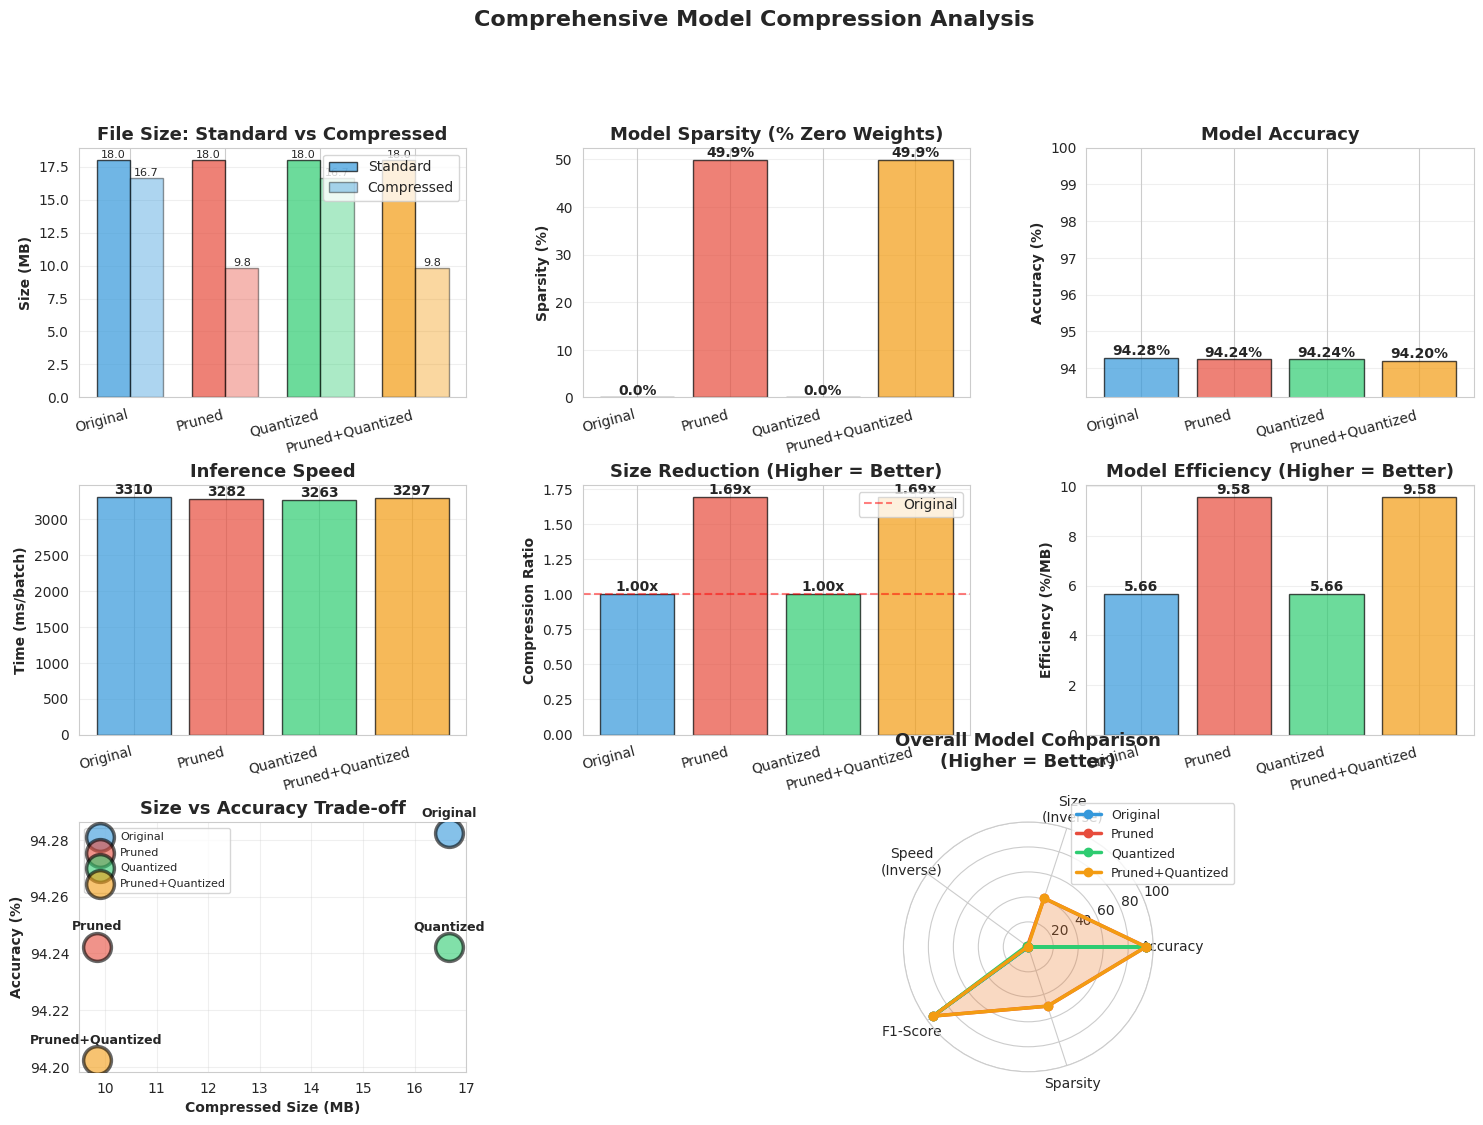


SUMMARY REPORT

📦 SIZE REDUCTION (Compressed):
  • Pruned              : 9.84 MB (+41.0% change)
  • Quantized           : 16.66 MB (+0.0% change)
  • Pruned+Quantized    : 9.84 MB (+41.0% change)

🎯 ACCURACY IMPACT:
  • Pruned              : 94.24% (-0.04% change)
  • Quantized           : 94.24% (-0.04% change)
  • Pruned+Quantized    : 94.20% (-0.08% change)

🏆 BEST MODEL FOR:
  • Smallest size:  Pruned+Quantized (9.84 MB)
  • Best accuracy:  Original (94.28%)
  • Fastest speed:  Quantized (3263 ms)
  • Best efficiency: Pruned



In [21]:
original_model = torch.load("/kaggle/input/psy-i-koty-modele-i-rezultaty/psy_i_koty_results/CNN_model/best_model.pth", weights_only=False, map_location=torch.device('cpu')).to("cpu")

# Run comprehensive comparison
results, df = compare_models_comprehensive(
    original_model=original_model,
    test_loader=test_loader,
    pruning_amount=0.5,  # Adjust if needed
    save_dir="real_compression_analysis"
)

# Model pretrained

To be done eventually